In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd

/var/folders/fn/mdlj31k14nbbd8zp9hwyjltr0000gn/T/ipykernel_6890/294991254.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


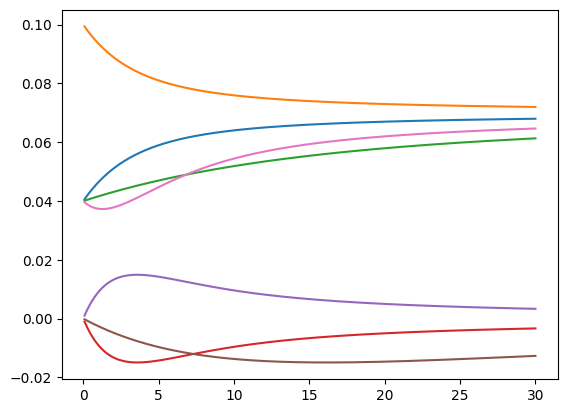

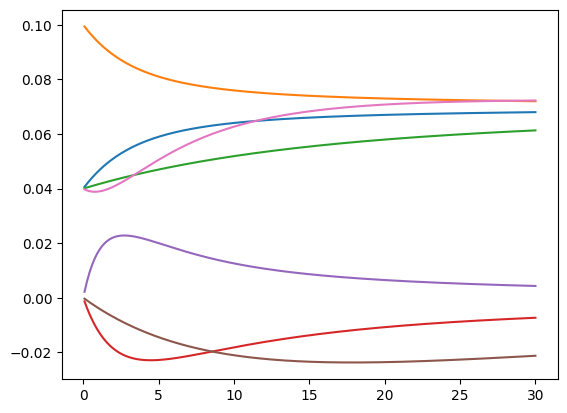

In [2]:
## QUESTION 1.1 : Visualiser les yield curves selon NS

def yield_curve(n, beta_0, beta_1, beta_2, tau_1): # NS
    return beta_0 + beta_1 * (1 - np.exp(-n / tau_1)) / (n / tau_1) + beta_2 * ((1 - np.exp(-n / tau_1)) / (n / tau_1) - np.exp(-n / tau_1))

params_NS = np.array([[0.07, -0.03, 0, 2],
                    [0.07, 0.03, 0, 2],
                    [0.07, -0.03, 0, 9],
                    [0,0,-0.05, 2],
                    [0,0,0.05,2],
                    [0,0,-0.05,9],
                    [0.07,-0.03,-0.05, 2]])

n = np.arange((1/12),30,(1/12))

for param in params_NS:
    plt.plot(n,yield_curve(n, *param))
plt.show()

## QUESTION 1.2 : Visualiser les yield curves selon Svensson
def yield_curve_SV(n, beta_0, beta_1, beta_2, beta_3, tau_1, tau_2): # Svensson
    return beta_0 + beta_1 * (1 - np.exp(-n / tau_1)) / (n / tau_1) + beta_2 * ((1 - np.exp(-n / tau_1)) / (n / tau_1) - np.exp(-n / tau_1)) + beta_3 * ((1 - np.exp(-n / tau_2)) / (n / tau_2) - np.exp(-n / tau_2))

params_SV = np.array([[0.07, -0.03, 0, 0, 2, 2],
                    [0.07, 0.03, 0, 0,  2, 5],
                    [0.07, -0.03, 0, 0, 9, 3],
                    [0,0,-0.05, -0.03, 2, 4],
                    [0,0,0.05, 0.03, 2, 1],
                    [0,0,-0.05, -0.03, 9, 12],
                    [0.07,-0.03,-0.05, 0.03, 2, 9]])

n = np.arange((1/12),30,(1/12))

for param in params_SV:
    plt.plot(n,yield_curve_SV(n, *param))
plt.show()

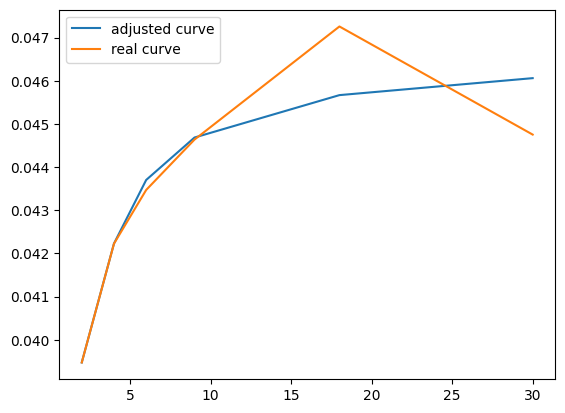

[ 0.04664961  3.15113442 -3.21805107  0.26426325]


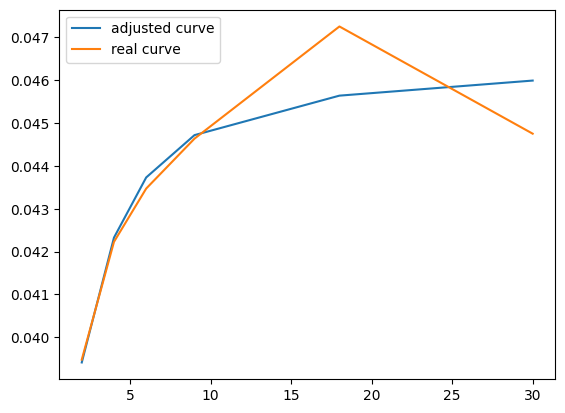

[ 0.04652066 -0.0136548   0.00574394  1.99912605]


In [3]:
## QUESTION 2.1 : Ajuster une courbe de taux par les taux (using curve_fit)
YTM = np.array([0.039475, 0.042226, 0.043471, 0.044637, 0.047257, 0.044753])
TTM = np.array([2,4,6,9,18,30])

popt, pcov = scipy.optimize.curve_fit(yield_curve, TTM, YTM)
adj_YTM = yield_curve(TTM, *popt)

plt.plot(TTM, adj_YTM, label ='adjusted curve')
plt.plot(TTM, YTM, label ='real curve')
plt.legend()
plt.show()

print(popt)

# Weird things happening for small maturities because of lack of data and optimization parameters

## QUESTION 2.2 : Ajuster une courbe de taux par les taux (using least squares)
YTM = np.array([0.039475, 0.042226, 0.043471, 0.044637, 0.047257, 0.044753])
TTM = np.array([2,4,6,9,18,30])

def least_squares(param, TTM, YTM):
    return np.sum((yield_curve(TTM, *param) - YTM)**2)

result = scipy.optimize.minimize(least_squares, np.array([0.07,-0.03,-0.05,2]), args=(TTM, YTM)).x
adj_YTM = yield_curve(TTM, *result)

plt.plot(TTM, adj_YTM, label ='adjusted curve')
plt.plot(TTM, YTM, label ='real curve')
plt.legend()
plt.show()

print(result)

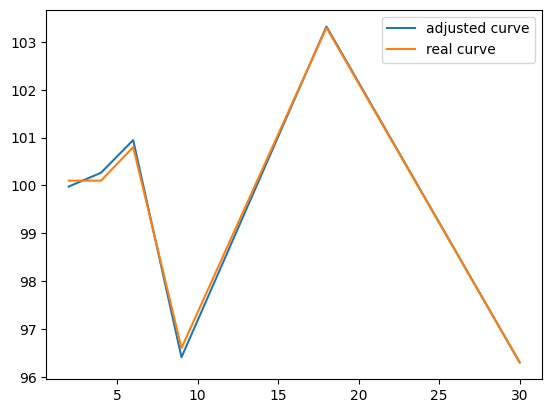

[-1.78984847  1.86703974  2.20244936 81.58505806]


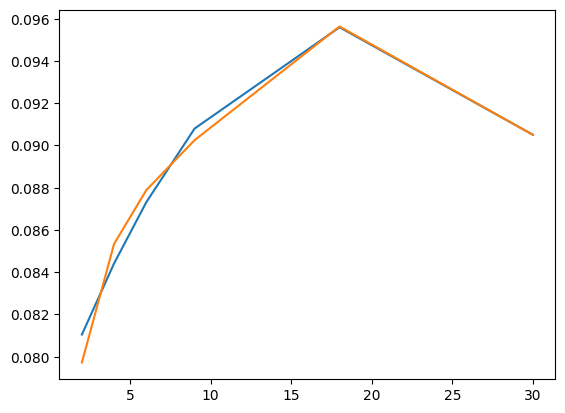

In [6]:
## QUESTION 3 : Ajuster une courbe de taux par les prix

# Prix moins directe, plus d'étapes -> perte de précision
# Svensson model, plus de paramètres -> fit mieux que Nelson-Siegel (plus petit MSE)

TTM = np.array([2,4,6,9,18,30])
PRICE = np.array([100.1, 100.1, 100.8,96.6,103.3,96.3])
C = np.array([0.04,0.0425,0.045,0.04,0.05,0.0425])

df = pd.DataFrame({'TTM': TTM, 'C': C})

def bond_price(df, params):
    ttm = df['TTM']
    coupon = df['C'] * 100/2
    y = yield_curve(ttm, *params)

    return sum([ coupon / ((1 + y/2) ** i) for i in np.arange(0.5, ttm + 0.5, 0.5)]) + 100 /((1 + y/2) ** ttm)

def duree(df, params):

    ttm = df['TTM']
    coupon = df['C'] * 100/2
    y = yield_curve(ttm, *params)

    duration = 0
    for t in np.arange(0.5, ttm + 0.5, 0.5):
        duration += t * coupon / (1 + y)**t
    duration += ttm * 100 / (1 + y)**ttm
    return duration / (1 + y)**ttm

def least_squares2(params, df, PRICE):
    estimated_prices = np.array([bond_price(df.iloc[i], params) for i in range(len(df))])
    estimated_duree = np.array([duree(df.iloc[i], params) for i in range(len(df))])
    return np.sum((estimated_prices - PRICE)**2/estimated_duree)

result = scipy.optimize.minimize(least_squares2, np.array([0.07,-0.03,-0.05,2]), args=(df, PRICE)).x
adj_prices = np.array([bond_price(df.iloc[i,], result) for i in range(len(df))])

# Visualisation de la courbe des prix réelles VS ajustées
plt.plot(TTM, adj_prices, label ='adjusted curve')
plt.plot(TTM, PRICE, label ='real curve')
plt.legend()
plt.show()

# Visualisation de la courbe des taux réelles VS ajustées 
# (il faut tout d'abord trouver les yields impliqués par les prix observés)
def get_price_by_yield(y, df):
    ttm = df['TTM']
    coupon = df['C'] * 100/2
    return sum([ coupon / ((1 + y/2) ** i) for i in np.arange(0.5, ttm + 0.5, 0.5)]) + 100 /((1 + y/2) ** ttm)

YIELD = []
for idx in range(len(df)) :
    YIELD.append(scipy.optimize.minimize(lambda y : abs(get_price_by_yield(y,df.iloc[idx,]) - PRICE[idx]), 0.10).x)

# Modéliser la courbe des taux 
plt.plot(TTM, yield_curve(TTM, *result), label ='adjusted curve')
plt.plot(TTM, YIELD, label ='real curve')

print(result)

In [ ]:
## QUESTION 4.1 : Ajuster la courbe aux données CRSP - NS

## QUESTION 4.2 : Ajuster la courbe aux données CRSP - Svensson
